In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting(use_latex='mathjax')

In [2]:
import numpy as np

In [3]:
a, b, c, d = sm.symbols('a, b, c, d')

mat = np.array([[a, b], [c, d]])
mat

array([[a, b],
       [c, d]], dtype=object)

In [4]:
sym_mat = sm.Matrix([[a, b], [c, d]])
eval_sym_mat = sm.lambdify((a, b, c, d), sym_mat)
num_mat = eval_sym_mat(1.0, 2.0, 3.0, 4.0)
num_mat

array([[1., 2.],
       [3., 4.]])

In [5]:
np.cos(5) + sm.cos(5)

cos(5) + 0.283662185463226

In [6]:
m, g, kt, kl, l = sm.symbols('m, g, k_t, k_l, l')
q1, q2, q3 = me.dynamicsymbols('q1, q2, q3')
u1, u2, u3 = me.dynamicsymbols('u1, u2, u3')

N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')

A.orient_axis(N, q1, N.z)
B.orient_axis(A, q2, A.x)

A.set_ang_vel(N, u1*N.z)
B.set_ang_vel(A, u2*A.x)

O = me.Point('O')
Ao = me.Point('A_O')
Bo = me.Point('B_O')
Q = me.Point('Q')

Ao.set_pos(O, l/2*A.x)
Bo.set_pos(O, l*A.x)
Q.set_pos(Bo, q3*B.y)

O.set_vel(N, 0)
Ao.v2pt_theory(O, N, A)
Bo.v2pt_theory(O, N, A)
Q.set_vel(B, u3*B.y)
Q.v1pt_theory(Bo, N, B)

t = me.dynamicsymbols._t

qdot_repl = {q1.diff(t): u1,
             q2.diff(t): u2,
             q3.diff(t): u3}

Q.set_acc(N, Q.acc(N).xreplace(qdot_repl))

R_Ao = m*g*N.x
R_Bo = m*g*N.x + kl*q3*B.y
R_Q = m/4*g*N.x - kl*q3*B.y
T_A = -kt*q1*N.z + kt*q2*A.x
T_B = -kt*q2*A.x

I = m*l**2/12
I_A_Ao = I*me.outer(A.y, A.y) + I*me.outer(A.z, A.z)
I_B_Bo = I*me.outer(B.x, B.x) + I*me.outer(B.z, B.z)

points = [Ao, Bo, Q]
forces = [R_Ao, R_Bo, R_Q]
masses = [m, m, m/4]

frames = [A, B]
torques = [T_A, T_B]
inertias = [I_A_Ao, I_B_Bo]

Fr_bar = []
Frs_bar = []

for ur in [u1, u2, u3]:

    Fr = 0
    Frs = 0

    for Pi, Ri, mi in zip(points, forces, masses):
        vr = Pi.vel(N).diff(ur, N)
        Fr += vr.dot(Ri)
        Rs = -mi*Pi.acc(N)
        Frs += vr.dot(Rs)

    for Bi, Ti, Ii in zip(frames, torques, inertias):
        wr = Bi.ang_vel_in(N).diff(ur, N)
        Fr += wr.dot(Ti)
        Ts = -(Bi.ang_acc_in(N).dot(Ii) +
               me.cross(Bi.ang_vel_in(N), Ii).dot(Bi.ang_vel_in(N)))
        Frs += wr.dot(Ts)

    Fr_bar.append(Fr)
    Frs_bar.append(Frs)

Fr = sm.Matrix(Fr_bar)
Frs = sm.Matrix(Frs_bar)

q = sm.Matrix([q1, q2, q3])
u = sm.Matrix([u1, u2, u3])

qd = q.diff(t)
ud = u.diff(t)

ud_zerod = {udr: 0 for udr in ud}

Mk = -sm.eye(3)
gk = u

Md = Frs.jacobian(ud)
gd = Frs.xreplace(ud_zerod) + Fr

In [7]:
q, u, qd, ud

⎛⎡q₁⎤  ⎡u₁⎤  ⎡q₁̇⎤  ⎡u₁̇⎤⎞
⎜⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎜⎢q₂⎥, ⎢u₂⎥, ⎢q₂̇⎥, ⎢u₂̇⎥⎟
⎜⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎝⎣q₃⎦  ⎣u₃⎦  ⎣q₃̇⎦  ⎣u₃̇⎦⎠

In [8]:
Mk, gk

⎛⎡-1  0   0 ⎤  ⎡u₁⎤⎞
⎜⎢          ⎥  ⎢  ⎥⎟
⎜⎢0   -1  0 ⎥, ⎢u₂⎥⎟
⎜⎢          ⎥  ⎢  ⎥⎟
⎝⎣0   0   -1⎦  ⎣u₃⎦⎠

In [9]:
Md, gd

⎛                                                                             
⎜⎡   2      2           2         2    2                                   ⎤  
⎜⎢  l ⋅m⋅cos (q₂)   19⋅l ⋅m   m⋅q₃ ⋅cos (q₂)  l⋅m⋅q₃⋅sin(q₂)  -l⋅m⋅cos(q₂) ⎥  
⎜⎢- ───────────── - ─────── - ──────────────  ──────────────  ─────────────⎥  
⎜⎢        12           12           4               4               4      ⎥  
⎜⎢                                                                         ⎥  
⎜⎢                                               2         2               ⎥  
⎜⎢              l⋅m⋅q₃⋅sin(q₂)                  l ⋅m   m⋅q₃                ⎥, 
⎜⎢              ──────────────                - ──── - ─────        0      ⎥  
⎜⎢                    4                          12      4                 ⎥  
⎜⎢                                                                         ⎥  
⎜⎢              -l⋅m⋅cos(q₂)                                       -m      ⎥  
⎜⎢              ─────────────                       

In [10]:
Mk.free_symbols | gk.free_symbols | Md.free_symbols | gd.free_symbols

{g, kₗ, kₜ, l, m, t}

In [11]:
p = sm.Matrix([g, kl, kt, l, m])
p

⎡g ⎤
⎢  ⎥
⎢kₗ⎥
⎢  ⎥
⎢kₜ⎥
⎢  ⎥
⎢l ⎥
⎢  ⎥
⎣m ⎦

In [12]:
eval_eom = sm.lambdify((q, u, p), [Mk, gk, Md, gd])

In [13]:
q_vals = np.array([
    np.deg2rad(25.0),  # q1, rad
    np.deg2rad(5.0),  # q2, rad
    0.1,  # q3, m
])
q_vals, type(q_vals), q_vals.shape

(array([0.43633231, 0.08726646, 0.1       ]), numpy.ndarray, (3,))

In [14]:
u_vals = np.array([
    0.1,  # u1, rad/s
    2.2,  # u2, rad/s
    0.3,  # u3, m/s
])
u_vals, type(u_vals), u_vals.shape

(array([0.1, 2.2, 0.3]), numpy.ndarray, (3,))

In [15]:
p_vals = np.array([
    9.81,  # g, m/s**2
    2.0,  # kl, N/m
    0.01,  # kt, Nm/rad
    0.6,  # l, m
    1.0,  # m, kg
])
p_vals, type(p_vals), p_vals.shape

(array([9.81, 2.  , 0.01, 0.6 , 1.  ]), numpy.ndarray, (5,))

In [16]:
Mk_vals, gk_vals, Md_vals, gd_vals = eval_eom(q_vals, u_vals, p_vals)
Mk_vals, gk_vals, Md_vals, gd_vals

(array([[-1,  0,  0],
        [ 0, -1,  0],
        [ 0,  0, -1]]),
 array([[0.1],
        [2.2],
        [0.3]]),
 array([[-0.60225313,  0.00130734, -0.1494292 ],
        [ 0.00130734, -0.0325    ,  0.        ],
        [-0.1494292 ,  0.        , -0.25      ]]),
 array([[-4.48963535],
        [-0.02486744],
        [-1.1112791 ]]))

In [17]:
qd_vals = np.linalg.solve(-Mk_vals, np.squeeze(gk_vals))
qd_vals

array([0.1, 2.2, 0.3])

In [18]:
ud_vals = np.linalg.solve(-Md_vals, np.squeeze(gd_vals))
ud_vals

array([-7.46056427, -1.06525862,  0.01418834])

In [19]:
np.linalg.solve(-Mk_vals, gk_vals)

array([[0.1],
       [2.2],
       [0.3]])

In [20]:
def euler_integrate(rhs_func, tspan, x0_vals, p_vals, delt=0.03):
    """Returns state trajectory and corresponding values of time resulting
    from integrating the ordinary differential equations with Euler's
    Method.

    Parameters
    ==========
    rhs_func : function
       Python function that evaluates the derivative of the state and takes
       this form ``dxdt = f(t, x, p)``.
    tspan : 2-tuple of floats
       The initial time and final time values: (t0, tf).
    x0_vals : array_like, shape(2*n,)
       Values of the state x at t0.
    p_vals : array_like, shape(o,)
       Values of constant parameters.
    delt : float
       Integration time step in seconds/step.

    Returns
    =======
    ts : ndarray(m, )
       Monotonically increasing values of time.
    xs : ndarray(m, 2*n)
       State values at each time in ts.

    """
    # generate monotonically increasing values of time.
    duration = tspan[1] - tspan[0]
    num_samples = round(duration/delt) + 1
    ts = np.arange(tspan[0], tspan[0] + delt*num_samples, delt)

    # create an empty array to hold the state values.
    x = np.empty((len(ts), len(x0_vals)))

    # set the initial conditions to the first element.
    x[0, :] = x0_vals

    # use a for loop to sequentially calculate each new x.
    for i, ti in enumerate(ts[:-1]):
        x[i + 1, :] = x[i, :] + delt*rhs_func(ti, x[i, :], p_vals)

    return ts, x

In [21]:
def eval_rhs(t, x, p):
    """Return the right hand side of the explicit ordinary differential
    equations which evaluates the time derivative of the state ``x`` at time
    ``t``.

    Parameters
    ==========
    t : float
       Time in seconds.
    x : array_like, shape(6,)
       State at time t: [q1, q2, q3, u1, u2, u3]
    p : array_like, shape(5,)
       Constant parameters: [g, kl, kt, l, m]

    Returns
    =======
    xd : ndarray, shape(6,)
        Derivative of the state with respect to time at time ``t``.

    """

    # unpack the q and u vectors from x
    q = x[:3]
    u = x[3:]

    # evaluate the equations of motion matrices with the values of q, u, p
    Mk, gk, Md, gd = eval_eom(q, u, p)

    # solve for q' and u'
    qd = np.linalg.solve(-Mk, np.squeeze(gk))
    ud = np.linalg.solve(-Md, np.squeeze(gd))

    # pack dq/dt and du/dt into a new state time derivative vector dx/dt
    xd = np.empty_like(x)
    xd[:3] = qd
    xd[3:] = ud

    return xd

In [22]:
x0 = np.empty(6)
x0[:3] = q_vals
x0[3:] = u_vals

t0 = 0.1

In [23]:
eval_rhs(t0, x0, p_vals)

array([ 0.1       ,  2.2       ,  0.3       , -7.46056427, -1.06525862,
        0.01418834])

In [24]:
tf = 2.0

ts, xs = euler_integrate(eval_rhs, (t0, tf), x0, p_vals)

In [25]:
ts

array([0.1 , 0.13, 0.16, 0.19, 0.22, 0.25, 0.28, 0.31, 0.34, 0.37, 0.4 ,
       0.43, 0.46, 0.49, 0.52, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7 , 0.73,
       0.76, 0.79, 0.82, 0.85, 0.88, 0.91, 0.94, 0.97, 1.  , 1.03, 1.06,
       1.09, 1.12, 1.15, 1.18, 1.21, 1.24, 1.27, 1.3 , 1.33, 1.36, 1.39,
       1.42, 1.45, 1.48, 1.51, 1.54, 1.57, 1.6 , 1.63, 1.66, 1.69, 1.72,
       1.75, 1.78, 1.81, 1.84, 1.87, 1.9 , 1.93, 1.96, 1.99])

In [26]:
type(ts), ts.shape

(numpy.ndarray, (64,))

In [27]:
xs

array([[ 4.36332313e-01,  8.72664626e-02,  1.00000000e-01,
         1.00000000e-01,  2.20000000e+00,  3.00000000e-01],
       [ 4.39332313e-01,  1.53266463e-01,  1.09000000e-01,
        -1.23816928e-01,  2.16804224e+00,  3.00425650e-01],
       [ 4.35617805e-01,  2.18307730e-01,  1.18012770e-01,
        -3.48867554e-01,  2.13303503e+00,  2.99423633e-01],
       [ 4.25151779e-01,  2.82298781e-01,  1.26995479e-01,
        -5.72475739e-01,  2.09463526e+00,  2.97361542e-01],
       [ 4.07977506e-01,  3.45137839e-01,  1.35916325e-01,
        -7.91929289e-01,  2.05197871e+00,  2.94628416e-01],
       [ 3.84219628e-01,  4.06697200e-01,  1.44755177e-01,
        -1.00444789e+00,  2.00382451e+00,  2.91554565e-01],
       [ 3.54086191e-01,  4.66811935e-01,  1.53501814e-01,
        -1.20715867e+00,  1.94877129e+00,  2.88335792e-01],
       [ 3.17871431e-01,  5.25275074e-01,  1.62151888e-01,
        -1.39708735e+00,  1.88551903e+00,  2.84974403e-01],
       [ 2.75958810e-01,  5.81840645e-01,  1.707

In [28]:
type(xs), xs.shape

(numpy.ndarray, (64, 6))

In [29]:
import matplotlib.pyplot as plt

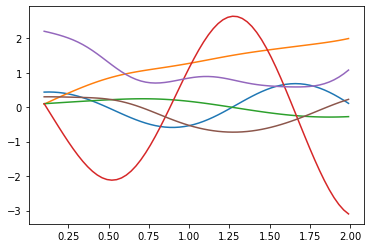

In [30]:
plt.plot(ts, xs);

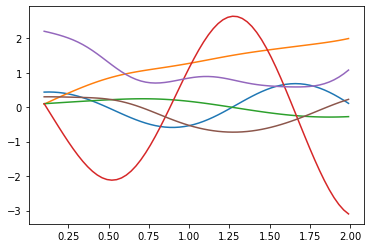

In [31]:
plt.plot(ts, xs)

In [32]:
def plot_results(ts, xs):
    """Returns the array of axes of a 4 panel plot of the state trajectory
    versus time.

    Parameters
    ==========
    ts : array_like, shape(m,)
       Values of time.
    xs : array_like, shape(m, 6)
       Values of the state trajectories corresponding to ``ts`` in order
       [q1, q2, q3, u1, u2, u3].

    Returns
    =======
    axes : ndarray, shape(4,)
       Matplotlib axes for each panel.

    """

    fig, axes = plt.subplots(4, 1, sharex=True)

    fig.set_size_inches((10.0, 6.0))

    axes[0].plot(ts, np.rad2deg(xs[:, :2]))
    axes[1].plot(ts, xs[:, 2])
    axes[2].plot(ts, np.rad2deg(xs[:, 3:5]))
    axes[3].plot(ts, xs[:, 5])

    axes[0].legend([me.vlatex(q[0], mode='inline'),
                    me.vlatex(q[1], mode='inline')])
    axes[1].legend([me.vlatex(q[2], mode='inline')])
    axes[2].legend([me.vlatex(u[0], mode='inline'),
                    me.vlatex(u[1], mode='inline')])
    axes[3].legend([me.vlatex(u[2], mode='inline')])

    axes[0].set_ylabel('Angle [deg]')
    axes[1].set_ylabel('Distance [m]')
    axes[2].set_ylabel('Angular Rate [deg/s]')
    axes[3].set_ylabel('Speed [m/s]')

    axes[3].set_xlabel('Time [s]')

    fig.tight_layout()

    return axes

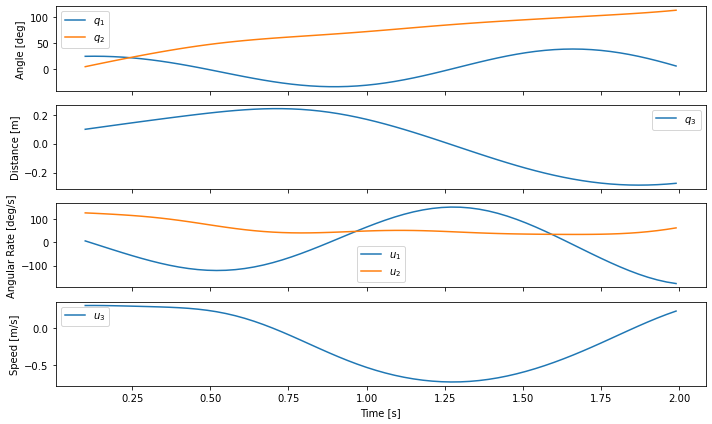

In [33]:
plot_results(ts, xs);

In [34]:
from scipy.integrate import solve_ivp

In [35]:
result = solve_ivp(eval_rhs, (t0, tf), x0, args=(p_vals,))

In [36]:
result.t

array([0.1       , 0.13120248, 0.29762659, 0.54422251, 0.80410512,
       1.06256808, 1.31993114, 1.57487353, 1.83715709, 2.        ])

In [37]:
result.y

array([[ 0.43633231,  0.4358189 ,  0.31525018, -0.11015295, -0.46375645,
        -0.34485627,  0.12132567,  0.43601266,  0.27143017, -0.01911091],
       [ 0.08726646,  0.15537688,  0.49605864,  0.88149593,  1.13596246,
         1.39359322,  1.67416762,  1.92225131,  2.13926064,  2.29230085],
       [ 0.1       ,  0.10935888,  0.15799993,  0.21797738,  0.21721945,
         0.11520445, -0.03955252, -0.17887644, -0.25034975, -0.24594355],
       [ 0.1       , -0.13284291, -1.26834506, -1.88255608, -0.55453818,
         1.39013663,  1.86357587,  0.37219434, -1.5003001 , -1.93004498],
       [ 2.2       ,  2.16517843,  1.90078084,  1.19931529,  0.90164316,
         1.09025742,  1.04941978,  0.88566504,  0.83634928,  1.07386933],
       [ 0.3       ,  0.299615  ,  0.28218305,  0.16978927, -0.2076191 ,
        -0.54349971, -0.61398805, -0.44313122, -0.08440758,  0.13024152]])

In [38]:
np.shape(result.y)

(6, 10)

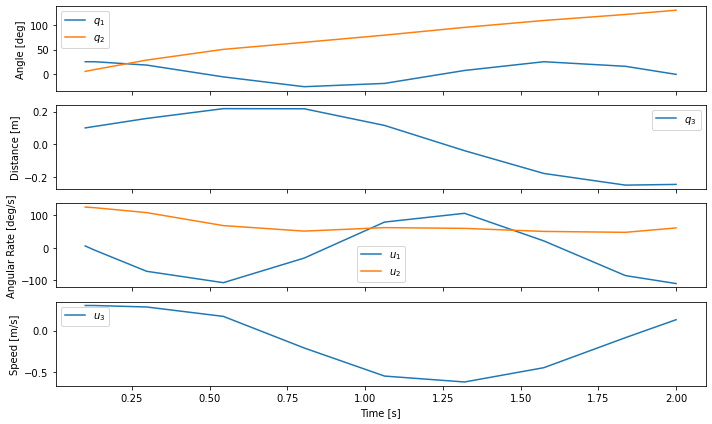

In [39]:
plot_results(result.t, np.transpose(result.y));

In [40]:
result = solve_ivp(eval_rhs, (t0, tf), x0, args=(p_vals,), t_eval=ts)

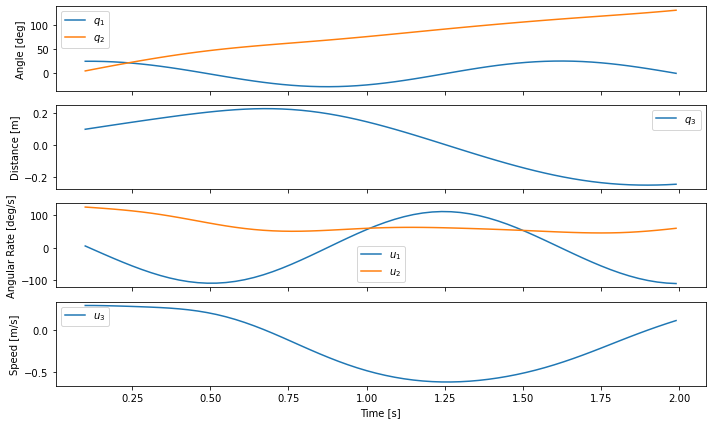

In [41]:
plot_results(result.t, np.transpose(result.y));

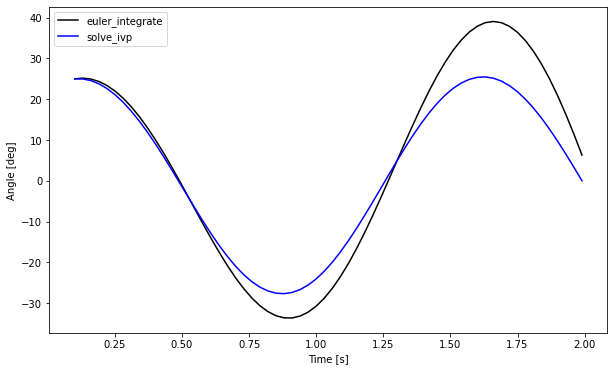

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches((10.0, 6.0))

ax.plot(ts, np.rad2deg(xs[:, 0]), 'k',
        result.t, np.rad2deg(np.transpose(result.y)[:, 0]), 'b');
ax.legend(['euler_integrate', 'solve_ivp'])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Angle [deg]');

In [43]:
xs = np.transpose(result.y)

In [44]:
M = me.ReferenceFrame('M')
M.orient_axis(N, sm.pi/2, N.z)

In [45]:
Bl = me.Point('B_l')
Br = me.Point('B_r')
Bl.set_pos(Bo, -l/2*B.y)
Br.set_pos(Bo, l/2*B.y)

In [46]:
coordinates = O.pos_from(O).to_matrix(M)
for point in [Bo, Q, Bl, Br]:
    coordinates = coordinates.row_join(point.pos_from(O).to_matrix(M))

eval_point_coords = sm.lambdify((q, p), coordinates)
eval_point_coords(q_vals, p_vals)

array([[ 0.        ,  0.25357096,  0.34385686, -0.01728675,  0.52442866],
       [ 0.        , -0.54378467, -0.50168367, -0.67008769, -0.41748165],
       [ 0.        ,  0.        ,  0.00871557, -0.02614672,  0.02614672]])

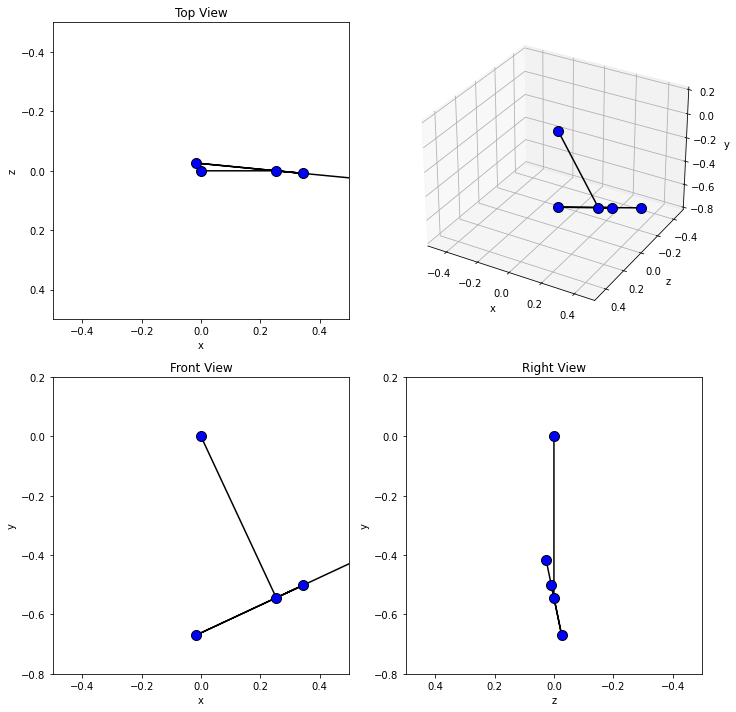

In [47]:
# initial configuration of the points
x, y, z = eval_point_coords(q_vals, p_vals)

# create a figure
fig = plt.figure()
fig.set_size_inches((10.0, 10.0))

# setup the subplots
ax_top = fig.add_subplot(2, 2, 1)
ax_3d = fig.add_subplot(2, 2, 2, projection='3d')
ax_front = fig.add_subplot(2, 2, 3)
ax_right = fig.add_subplot(2, 2, 4)

# common line and marker properties for each panel
line_prop = {
    'color': 'black',
    'marker': 'o',
    'markerfacecolor': 'blue',
    'markersize': 10,
}

# top view
lines_top, = ax_top.plot(x, z, **line_prop)
ax_top.set_xlim((-0.5, 0.5))
ax_top.set_ylim((0.5, -0.5))
ax_top.set_title('Top View')
ax_top.set_xlabel('x')
ax_top.set_ylabel('z')
ax_top.set_aspect('equal')

# 3d view
lines_3d, = ax_3d.plot(x, z, y, **line_prop)
ax_3d.set_xlim((-0.5, 0.5))
ax_3d.set_ylim((0.5, -0.5))
ax_3d.set_zlim((-0.8, 0.2))
ax_3d.set_xlabel('x')
ax_3d.set_ylabel('z')
ax_3d.set_zlabel('y')

# front view
lines_front, = ax_front.plot(x, y, **line_prop)
ax_front.set_xlim((-0.5, 0.5))
ax_front.set_ylim((-0.8, 0.2))
ax_front.set_title('Front View')
ax_front.set_xlabel('x')
ax_front.set_ylabel('y')
ax_front.set_aspect('equal')

# right view
lines_right, = ax_right.plot(z, y, **line_prop)
ax_right.set_xlim((0.5, -0.5))
ax_right.set_ylim((-0.8, 0.2))
ax_right.set_title('Right View')
ax_right.set_xlabel('z')
ax_right.set_ylabel('y')
ax_right.set_aspect('equal')

fig.tight_layout()

In [48]:
from matplotlib.animation import FuncAnimation

In [49]:
def animate(i):
    x, y, z = eval_point_coords(xs[i, :3], p_vals)
    lines_top.set_data(x, z)
    lines_3d.set_data_3d(x, z, y)
    lines_front.set_data(x, y)
    lines_right.set_data(z, y)

In [50]:
ani = FuncAnimation(fig, animate, len(ts))

In [51]:
from IPython.display import HTML

HTML(ani.to_jshtml(fps=30))